Import necesary libraries

In [49]:
import matplotlib.pyplot as plt
import csv
import time
import math
import numpy as np
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from prettytable import PrettyTable
import statistics

Declare variables

In [50]:
_wp_x, _wp_y, _wp_yaw = [[] for _ in range(3)]
_ekf_x, _ekf_y, _ekf_yaw, _ekf_status = [[] for _ in range(4)]
_gnss_x, _gnss_y, _gnss_yaw = [[] for _ in range(3)]
_ndt_x, _ndt_y, _ndt_yaw, _ndt_exec_time = [[] for _ in range(4)]
_ekf_time, _gnss_time, _ndt_time = [[] for _ in range(3)]
_ekf_xy_error, _gnss_xy_error, _ndt_xy_error = [[] for _ in range(3)]
_ekf_yaw_error, _gnss_yaw_error, _ndt_yaw_error = [[] for _ in range(3)]
_weight_time, _weight_gnss, _weight_ndt, _weight_stdev, _weight_score = [[] for _ in range(5)]

_ekfo_time, _ekfo_x, _ekfo_y, _ekfo_yaw, _ekfo_status, _ekfo_xy_error, _ekfo_yaw_error = [[] for _ in range(7)]
_ndto_time, _ndto_x, _ndto_y, _ndto_yaw, _ndto_score, _ndto_exec_time, _ndto_xy_error, _ndto_yaw_error = [[] for _ in range(8)]


Declare functions

In [51]:
def nearest_idx(x, y, line_x, line_y):
    assert len(line_x) == len(line_y)  # make sure arrays are the same length
    if len(line_x) < 2:
        raise ValueError("line arrays must have at least two elements")
    # Point and trajectory
    point = np.array([x, y])
    traject = np.array([line_x, line_y])
    # Subtract the point from the array of points
    diff = traject.T - point
    # Calculate the distances between the trajectory and the point
    dist = np.linalg.norm(diff, axis=1)
    # Find the index of the nearest distance
    idx = dist.argmin()
    
    # Create points
    p_A = np.array([line_x[idx], line_y[idx]])
    p_B = np.array([line_x[idx + 1], line_y[idx + 1]])
    p_C = np.array([x, y])
    # Create vectors
    AB = p_B - p_A
    AC = p_C - p_A
    # Calculate dot product of AC and AB
    dot = np.dot(AC, AB)
    # Calculate magnitude of AB
    AB_mag = np.linalg.norm(AB)
    # Check if perpendicular distance is before A
    if dot < 0:
        # print("Perpendicular distance is before A.")
        idx -= 1
    elif 0 < dot < AB_mag:
        # print("Perpendicular distance is between A and B.")
        idx += 0
    elif dot > AB_mag:
        # print("Perpendicular distance is after B.")
        idx += 1 #if idx < len(line_x) else 1
    
    return idx

def distance_to_line(x, y, x1, y1, x2, y2):
    # Create points
    p_A = np.array([x1, y1])
    p_B = np.array([x2, y2])
    p_C = np.array([x, y])
    # Create vectors
    AB = p_B - p_A
    AC = p_C - p_A
    # Calculate magnitude of AB
    AB_mag = np.linalg.norm(AB)
    # Calculate cross product of AP and AB
    cross = np.cross(AC, AB)
    # Calculate distance
    dist = abs(cross) / AB_mag
    return dist

def orientation_error(yaw_p, yaw_traj):
    # convert yaw to degrees
    yaw_p = np.deg2rad(yaw_p)
    # Keep angle between -pi and pi
    if yaw_p < math.pi:
        yaw_p += 2*math.pi
    if yaw_p > math.pi:
        yaw_p -= 2*math.pi
    # Calculate the orientation error
    angle_error = np.abs(np.abs(yaw_traj) - np.abs(yaw_p))
    # Return the angle in degrees
    return angle_error

def add_dotted_square(ax, x, y, square_text):
    
    x_min = min(x)
    x_max = max(x)
    y_min = min(y)
    y_max = max(y)
    
    # Calculate the width and height of the rectangle
    width = x_max - x_min
    height = y_max - y_min

    # Create a rectangle in data coordinates
    square = patches.Rectangle((x_min, y_min), width, height, linestyle='dotted', edgecolor='red', facecolor='none', transform=ax.transData)
    ax.add_patch(square)
    
    # Add text on top of the square
    ax.text(x_max + 0.1, (y_min + y_max)/2, square_text, ha='left', va='center', color='red')
    
def create_combined_legend(ax1, ax2):
    handles, labels = [], []
    for ax in [ax1, ax2]:
        for h, l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)
    legend = ax1.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 1), ncol=2)
    ax1.add_artist(legend)
    ax1.grid(True, linestyle='dotted')

Load data and fill variables

In [52]:
with open('saved_waypoints.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(reader)
    for row in reader:
        _wp_x.append(float(row[1]))
        _wp_y.append(float(row[2]))
        _wp_yaw.append(float(row[4]))

In [53]:
with open('ekf_lidar_gnss.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(reader)
    
    _idx_start, _idx_end, _idx_len, _idx_max = 0, 50, 50, len(_wp_x)
    for i, row in enumerate(reader):
        if i == 0:
            _time_0 = float(row[0])
        
        # ekf1 data    
        if row[10] and row[13]:
            _time = float(row[0])
            _x, _y, _yaw, _status = map(float, (row[10], row[11], row[8], row[13]))
            _ekf_time.append(_time - _time_0)
            _ekf_x.append(_x)
            _ekf_y.append(_y)
            _ekf_yaw.append(_yaw)
            _ekf_status.append(_status)
            _idx = nearest_idx(_x, _y, _wp_x[_idx_start:_idx_end], _wp_y[_idx_start:_idx_end])
            _idx_start += _idx if _idx_start + _idx > 0 else 0
            _idx_end = _idx_start + _idx_len if _idx_start + _idx_len <= _idx_max else _idx_max
            _ekf_xy_error.append(distance_to_line(_x, _y, _wp_x[_idx_start], _wp_y[_idx_start], _wp_x[_idx_start + 1], _wp_y[_idx_start + 1]))
            _ekf_yaw_error.append(np.rad2deg(orientation_error(_yaw, _wp_yaw[_idx_start + 2])))
        
        # gnss data    
        if row[23] != '':
            _x, _y, _yaw = map(float, (row[23], row[24], row[21]))
            _gnss_time.append(_time - _time_0)
            _gnss_x.append(_x)
            _gnss_y.append(_y)
            _gnss_yaw.append(_yaw)
            _gnss_xy_error.append(distance_to_line(_x, _y, _wp_x[_idx_start], _wp_y[_idx_start], _wp_x[_idx_start + 1], _wp_y[_idx_start + 1]))
            _gnss_yaw_error.append(np.rad2deg(orientation_error(_yaw, _wp_yaw[_idx_start + 2])))
        
        # ndt data    
        if row[35] != '':
            _x, _y, _yaw = map(float, (row[35], row[36], row[33]))
            _ndt_time.append(_time - _time_0)
            _ndt_x.append(_x)
            _ndt_y.append(_y)
            _ndt_yaw.append(_yaw)            
            _ndt_xy_error.append(distance_to_line(_x, _y, _wp_x[_idx_start], _wp_y[_idx_start], _wp_x[_idx_start + 1], _wp_y[_idx_start + 1]))
            _ndt_yaw_error.append(np.rad2deg(orientation_error(_yaw, _wp_yaw[_idx_start + 2])))
        
        if row[38] != '' and row[39] != '' and row[41] != '' and row[42] != '':
            _gnss, _stdev, _ndt, _score = map(float, (row[38], row[39], row[41], row[42]))
            _weight_time.append(_time - _time_0)
            _weight_gnss.append(_gnss)
            _weight_ndt.append(_ndt)
            _weight_stdev.append(_stdev)
            _weight_score.append(_score)

In [54]:
with open('ekf_lidar.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(reader)
    
    _idxo_start, _idxo_end, _idxo_len, _idxo_max = 0, 50, 50, len(_wp_x)
    for i, row in enumerate(reader):
        if i == 0:
            _timeo_0 = float(row[0])
            
        # ekf0 data
        if row[10] and row[13]:
            _timeo = float(row[0])
            _xo, _yo, _yawo, _statuso = map(float, (row[10], row[11], row[8], row[13]))
            _ekfo_time.append(_timeo - _timeo_0)
            _ekfo_x.append(_xo)
            _ekfo_y.append(_yo)
            _ekfo_yaw.append(_yawo)
            _ekfo_status.append(_statuso)
            _idxo = nearest_idx(_xo, _yo, _wp_x[_idxo_start:_idxo_end], _wp_y[_idxo_start:_idxo_end])
            _idxo_start += _idxo if _idxo_start + _idxo > 0 else 0
            _idxo_end = _idxo_start + _idxo_len if _idxo_start + _idxo_len <= _idxo_max else _idxo_max
            _ekfo_xy_error.append(distance_to_line(_xo, _yo, _wp_x[_idxo_start], _wp_y[_idxo_start], _wp_x[_idxo_start + 1], _wp_y[_idxo_start + 1]))
            _ekfo_yaw_error.append(np.rad2deg(orientation_error(_yawo, _wp_yaw[_idxo_start + 2])))
        
        # ndt data
        if row[35] != '':
            _xo, _yo, _yawo = map(float, (row[35], row[36], row[33]))
            _ndto_time.append(_timeo - _timeo_0)
            _ndto_x.append(_xo)
            _ndto_y.append(_yo)
            _ndto_yaw.append(_yawo)            
            _ndto_xy_error.append(distance_to_line(_x, _y, _wp_x[_idxo_start], _wp_y[_idxo_start], _wp_x[_idxo_start + 1], _wp_y[_idxo_start + 1]))
            _ndto_yaw_error.append(np.rad2deg(orientation_error(_yawo, _wp_yaw[_idxo_start + 2])))

Define evaluation times

In [55]:
_eval_time1 = 150
_eval_time2 = 160
_eval_time3 = 230
_eval_time4 = 240
_eval_time5 = 380
_eval_time6 = 400
_cent_time1 = (_eval_time2 + _eval_time1)/2
_cent_time2 = (_eval_time3 + _eval_time4)/2
_cent_time3 = (_eval_time5 + _eval_time6)/2

_idx_time1 = (np.abs(np.array(_ekf_time) - _eval_time1)).argmin()
_idx_time2 = (np.abs(np.array(_ekf_time) - _eval_time2)).argmin()
_idx_time3 = (np.abs(np.array(_ekf_time) - _eval_time3)).argmin()
_idx_time4 = (np.abs(np.array(_ekf_time) - _eval_time4)).argmin()
_idx_time5 = (np.abs(np.array(_ekf_time) - _eval_time5)).argmin()
_idx_time6 = (np.abs(np.array(_ekf_time) - _eval_time6)).argmin()
_idx_ctime1 = (np.abs(np.array(_ekf_time) - _cent_time1)).argmin()
_idx_ctime2 = (np.abs(np.array(_ekf_time) - _cent_time2)).argmin()
_idx_ctime3 = (np.abs(np.array(_ekf_time) - _cent_time3)).argmin()

Create figures for XY

Text(3.141592653589793, 3.141592653589793, '')

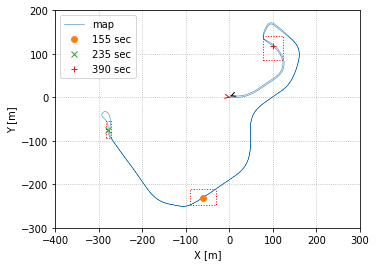

In [56]:
x12 = [_ekf_x[_idx_time1], _ekf_x[_idx_time2]]
y12 = [_ekf_y[_idx_time1], _ekf_y[_idx_time2]]
x34 = [_ekf_x[_idx_time3], _ekf_x[_idx_time4]]
y34 = [_ekf_y[_idx_time3], _ekf_y[_idx_time4]]
x56 = [_ekf_x[_idx_time5], _ekf_x[_idx_time6]]
y56 = [_ekf_y[_idx_time5], _ekf_y[_idx_time6]]

fig, ax = plt.subplots()
ax.plot(_wp_x, _wp_y, label='map', linewidth=0.5)
ax.plot(_ekf_x[_idx_ctime1], _ekf_y[_idx_ctime1], 'o', label='155 sec')
ax.plot(_ekf_x[_idx_ctime2], _ekf_y[_idx_ctime2], 'x', label='235 sec')
ax.plot(_ekf_x[_idx_ctime3], _ekf_y[_idx_ctime3], '+', label='390 sec')
add_dotted_square(ax, x12, y12, '')
add_dotted_square(ax, x34, y34, '')
add_dotted_square(ax, x56, y56, '')
ax.set_xlim(-400, 300)
ax.set_ylim(-300, 200)
ax.grid(True, linestyle='dotted')
ax.legend(loc='upper left')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_aspect('equal')

# Add arrows to the start and end of the plot
ax.annotate('', xy=(_wp_x[0], _wp_y[0]), xytext=(0, 0) , arrowprops=dict(color='red', arrowstyle='->'))
ax.annotate('', xy=(_wp_x[-1], _wp_y[-1]), xytext=(np.pi, np.pi) , arrowprops=dict(color='black', arrowstyle='->'))


Create figures for lateral and angular errors

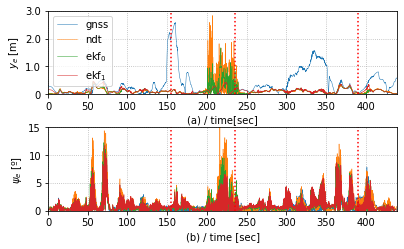

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14/2.54, 8.5/2.54))
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98, wspace=0.15, hspace=0.4)

ax1.plot(_gnss_time, _gnss_xy_error, label='gnss', linewidth=0.5)
ax1.plot(_ndt_time, _ndt_xy_error, label='ndt', linewidth=0.5)
ax1.plot(_ekfo_time, _ekfo_xy_error, label='ekf$_0$', linewidth=0.5)
ax1.plot(_ekf_time, _ekf_xy_error, label='ekf$_1$', linewidth=0.5)
ax1.set_xlim(0,440)
ax1.set_ylim(0,3)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(['0', '1.0', '2.0', '3.0'])
ax1.set_xlabel('(a) / time[sec]')
ax1.set_ylabel('$y_e$ [m]')
ax1.legend(loc='upper left')#, bbox_to_anchor=(0, 1), ncol=3)
ax1.grid(True, linestyle='dotted')
ax1.axvline(x=_cent_time1, color='red', linestyle='dotted')
ax1.axvline(x=_cent_time2, color='red', linestyle='dotted')
ax1.axvline(x=_cent_time3, color='red', linestyle='dotted')

ax2.plot(_gnss_time, _gnss_yaw_error, label='gnss', linewidth=0.5)
ax2.plot(_ndt_time, _ndt_yaw_error, label='ndt', linewidth=0.5)
ax2.plot(_ekfo_time, _ekfo_yaw_error, label='ekf$_0$', linewidth=0.5)
ax2.plot(_ekf_time, _ekf_yaw_error, label='ekf$_1$', linewidth=0.5)
ax2.set_xlim(0,440)
ax2.set_ylim(0,15)
ax2.set_yticks([0, 5, 10, 15])
ax2.set_yticklabels(['0', '5', '10', '15'])
ax2.set_xlabel('(b) / time [sec]')
ax2.set_ylabel(r'$\psi_e$ [º]')
ax2.grid(True, linestyle='dotted')
ax2.axvline(x=_cent_time1, color='red', linestyle='dotted')
ax2.axvline(x=_cent_time2, color='red', linestyle='dotted')
ax2.axvline(x=_cent_time3, color='red', linestyle='dotted')

See rms and max results in table format

In [58]:
_gnss_xy_mean = round(statistics.median(_gnss_xy_error), 2)
_gnss_xy_rms = round(np.sqrt(np.mean(np.square(_gnss_xy_error))), 2)
_gnss_xy_max = round(np.max(_gnss_xy_error), 2)
_gnss_xy_count = np.count_nonzero(np.array(_gnss_xy_error) < 0.2)
_gnss_xy_perce = round(_gnss_xy_count / len(_gnss_xy_error) * 100, 2)
_ndt_xy_mean = round(statistics.median(_ndt_xy_error), 2)
_ndt_xy_rms = round(np.sqrt(np.mean(np.square(_ndt_xy_error))), 2)
_ndt_xy_max = round(np.max(_ndt_xy_error), 2)
_ndt_xy_count = np.count_nonzero(np.array(_ndt_xy_error) < 0.2)
_ndt_xy_perce = round(_ndt_xy_count / len(_ndt_xy_error) * 100, 1)
_ekfo_xy_mean = round(statistics.median(_ekfo_xy_error), 2)
_ekfo_xy_rms = round(np.sqrt(np.mean(np.square(_ekfo_xy_error))), 2)
_ekfo_xy_max = round(np.max(_ekfo_xy_error), 2)
_ekfo_xy_count = np.count_nonzero(np.array(_ekfo_xy_error) < 0.2)
_ekfo_xy_perce = round(_ekfo_xy_count / len(_ekfo_xy_error) * 100, 1)
_ekf_xy_mean = round(statistics.median(_ekf_xy_error), 2)
_ekf_xy_rms = round(np.sqrt(np.mean(np.square(_ekf_xy_error))), 2)
_ekf_xy_max = round(np.max(_ekf_xy_error), 2)
_ekf_xy_count = np.count_nonzero(np.array(_ekf_xy_error) < 0.2)
_ekf_xy_perce = round(_ekf_xy_count / len(_ekf_xy_error) * 100, 1)

_gnss_yaw_mean = round(statistics.median(_gnss_yaw_error), 2)
_gnss_yaw_rms = round(np.sqrt(np.mean(np.square(_gnss_yaw_error))), 2)
_gnss_yaw_max = round(np.max(_gnss_yaw_error), 2)
_gnss_yaw_count = np.count_nonzero(np.array(_gnss_yaw_error) < 2)
_gnss_yaw_perce = round(_gnss_yaw_count / len(_gnss_yaw_error) * 100, 1)
_ndt_yaw_mean = round(statistics.median(_ndt_yaw_error), 2)
_ndt_yaw_rms = round(np.sqrt(np.mean(np.square(_ndt_yaw_error))), 2)
_ndt_yaw_max = round(np.max(_ndt_yaw_error), 2)
_ndt_yaw_count = np.count_nonzero(np.array(_ndt_yaw_error) < 2)
_ndt_yaw_perce = round(_ndt_yaw_count / len(_ndt_yaw_error) * 100, 1)
_ekfo_yaw_mean = round(statistics.median(_ekfo_yaw_error), 2)
_ekfo_yaw_rms = round(np.sqrt(np.mean(np.square(_ekfo_yaw_error))), 2)
_ekfo_yaw_max = round(np.max(_ekfo_yaw_error), 2)
_ekfo_yaw_count = np.count_nonzero(np.array(_ekfo_yaw_error) < 2)
_ekfo_yaw_perce = round(_ekfo_yaw_count / len(_ekfo_yaw_error) * 100, 1)
_ekf_yaw_mean = round(statistics.median(_ekf_yaw_error), 2)
_ekf_yaw_rms = round(np.sqrt(np.mean(np.square(_ekf_yaw_error))), 2)
_ekf_yaw_max = round(np.max(_ekf_yaw_error), 2)
_ekf_yaw_count = np.count_nonzero(np.array(_ekf_yaw_error) < 2)
_ekf_yaw_perce = round(_ekf_yaw_count / len(_ekf_yaw_error) * 100, 1)

# Create a table object
table = PrettyTable()

# Add columns
table.add_column("", ["gnss", "ndt", "ekfo", "ekf1"])
table.add_column("μ", [_gnss_xy_mean, _ndt_xy_mean, _ekfo_xy_mean, _ekf_xy_mean])
table.add_column("σ", [_gnss_xy_rms, _ndt_xy_rms, _ekfo_xy_rms, _ekf_xy_rms])
table.add_column("max", [_gnss_xy_max, _ndt_xy_max, _ekfo_xy_max, _ekf_xy_max])
table.add_column("<0.2m", [_gnss_xy_perce, _ndt_xy_perce, _ekfo_xy_perce, _ekf_xy_perce])
table.add_column("μ", [_gnss_yaw_mean, _ndt_yaw_mean, _ekfo_yaw_mean, _ekf_yaw_mean])
table.add_column("σ", [_gnss_yaw_rms, _ndt_yaw_rms, _ekfo_yaw_rms, _ekf_yaw_rms])
table.add_column("max", [_gnss_yaw_max, _ndt_yaw_max, _ekfo_yaw_max, _ekf_yaw_max])
table.add_column("<2.0º", [_gnss_yaw_perce, _ndt_yaw_perce, _ekfo_yaw_perce, _ekf_yaw_perce])

# Print the table
print(table)

+------+------+------+------+-------+------+------+-------+-------+
|      |  μ   |  σ   | max  | <0.2m |  μ   |  σ   |  max  | <2.0º |
+------+------+------+------+-------+------+------+-------+-------+
| gnss | 0.21 | 0.58 | 2.58 | 47.16 | 0.54 | 1.75 | 12.81 |  86.9 |
| ndt  | 0.09 | 0.19 | 2.83 |  89.6 | 0.67 | 2.15 | 20.68 |  83.4 |
| ekfo | 0.09 | 0.18 | 1.67 |  87.2 | 0.55 | 1.47 | 12.28 |  90.1 |
| ekf1 | 0.1  | 0.15 | 0.48 |  86.6 | 0.65 | 1.44 | 11.77 |  90.0 |
+------+------+------+------+-------+------+------+-------+-------+


Create figures for weigths

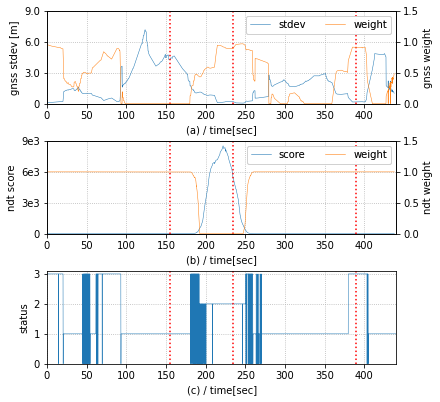

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(14/2.54, 15/2.54))
plt.subplots_adjust(left=0.1, right=0.98, bottom=0.15, top=0.98, wspace=0.15, hspace=0.4)

ax1.plot(_weight_time, _weight_stdev, label='stdev', linewidth=0.5, color='#1f77b4')
ax1.set_xlim(0,440)
ax1.set_ylim(0,9)
ax1.set_yticks([0, 3, 6, 9])
ax1.set_yticklabels(['0', '3.0', '6.0', '9.0'])
ax1.set_xlabel('(a) / time[sec]')
ax1.set_ylabel('gnss stdev [m]')
_ax1 = ax1.twinx()
_ax1.plot(_weight_time, _weight_gnss, label='weight', linewidth=0.5, color='#ff7f0e')
_ax1.set_xlim(0,440)
_ax1.set_ylim(0,1.5)
_ax1.set_ylabel('gnss weight')
create_combined_legend(ax1, _ax1)
ax1.axvline(x=_cent_time1, color='red', linestyle='dotted')
ax1.axvline(x=_cent_time2, color='red', linestyle='dotted')
ax1.axvline(x=_cent_time3, color='red', linestyle='dotted')

ax2.plot(_weight_time, _weight_score, label='score', linewidth=0.5, color='#1f77b4')
ax2.set_xlim(0,440)
ax2.set_ylim(0,9000)
ax2.set_yticks([0, 3000, 6000, 9000])
ax2.set_yticklabels(['0', '3e3', '6e3', '9e3'])
ax2.set_xlabel('(b) / time[sec]')
ax2.set_ylabel('ndt score')
_ax2 = ax2.twinx()
_ax2.plot(_weight_time, _weight_ndt, label='weight', linewidth=0.5, color='#ff7f0e')
_ax2.set_xlim(0,440)
_ax2.set_ylim(0,1.5)
_ax2.set_ylabel('ndt weight')
create_combined_legend(ax2, _ax2)
ax2.axvline(x=_cent_time1, color='red', linestyle='dotted')
ax2.axvline(x=_cent_time2, color='red', linestyle='dotted')
ax2.axvline(x=_cent_time3, color='red', linestyle='dotted')

ax3.plot(_ekf_time, _ekf_status, label='status', linewidth=0.5)
ax3.set_xlim(0,440)
ax3.set_ylim(0,3.1)
ax3.set_yticks([0, 1, 2, 3])
ax3.set_yticklabels(['0', '1', '2', '3'])
ax3.set_xlabel('(c) / time[sec]')
ax3.set_ylabel('status')
ax3.grid(True, linestyle='dotted')
ax3.axvline(x=_cent_time1, color='red', linestyle='dotted')
ax3.axvline(x=_cent_time2, color='red', linestyle='dotted')
ax3.axvline(x=_cent_time3, color='red', linestyle='dotted')